## 2. Redes Neurais

### Objetivos

  - Conhecer e praticar Arquiteturas complexas de Redes Neurais Convolucionais 
  - Aprendizagem por transferência
  - Praticar a classificação de objeto usando framework TensorFlow
  

## Arquitetura de Redes Neurais Convolucionais

Existem diversas arquitetura de CNN, cada rede com suas próprias características, principalmente para visão computacional. Mas todas terão em comum camadas de convolução e maxpooling, dropout.

### Por que utilizar uma arquitetura CNN

Utilizar uma arquitetura de CNN possibilita reduzir o tempo de pesquisa com o desenvolvimento de novas arquiteturas uma vez que essas arquiteturas já foram sistematicamente revisadas.



### Exemplos de arquiteturas:

`LeNET`: foi proposta em 1998 e já continha camadas de convolução com filtros 5x5 e passo 1, e agrupamentos com filtros 2x2 com passo 2, intercaladas, seguidas de camadas FC. A sequência de camadas eram: CONV-POOL-CONV-POOL-FC-FC.

`AlexNET`: proposta em 2012, bem mais complexa que a LeNET. Essa arquitetura continha cinco camadas de convolução, batch de tamanho 128, e primeiro uso da função de ativação ReLU.

`VGG`: em 2014 surge a arquitetura VGG com a ideia de filtros menores (3x3) em redes mais profundas com mínimo de 12 convoluções e maxpooling com filtros 2x2. Filtros menores geram menos parâmetros. Porém as camadas FC geravam uma quantidade muito grande de parâmetros e, as convoluções iniciais utilizavam muita memória RAM, tornando essa rede muito pesada.

`GoogleNET`: também em 2014 surgiu a ideia de se utilizar filtros de forma paralela, mais especificamente, fazer uso de uma nova camada chamada Inception, que se tornou elemento básico desta rede, onde tinha-se em sequência, nove módulos do tipo Inception. Este módulo possui convoluções 3x3 e 5x5 precedidas de convoluções 1x1 a fim de se reduzir o custo computacional.

`ResNET`: ou rede residual, proposta em 2015, de forma simplificada, a ideia é de se realizar um curto-circuito a cada duas convoluções, acrescentando um resultado anterior ao resultado futuro. Assim, diferentemente de uma rede tradicional, quanto mais camadas, menor o erro. Porém para os atuais projetos ResNET de 50, 101 e 152 camadas, ao invés de se trabalhar com 2 camadas convolucionais de 3x3, uma é retirada e são inseridas duas convoluções 1x1, diminuindo o custo computacional, como visto na GoogleNET.



### Modelos de CNN pré-treinados

O treinamento de uma boa CNN não é simples, além de muitos dados (milhares de imagens) e muito tempo de processamento.

### Aprendizagem por transferência de uma rede pré-treinada

Uma forma de contornar esse problema é a utilização de redes pré-treinadas com conjunto de dados de milhares de imagens, o que garante uma boa acurácia.

É possível ajustar os pesos das últimas camadas da rede para detectar apenas os recursos relevantes para o problema específico.


In [2]:
#Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras

In [5]:
import tensorflow_datasets as tfds


from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


tfds.disable_progress_bar()

# split the data manually into 80% training, 10% testing, 10% validation
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dataset cats_vs_dogs downloaded and prepared to /home/iot/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


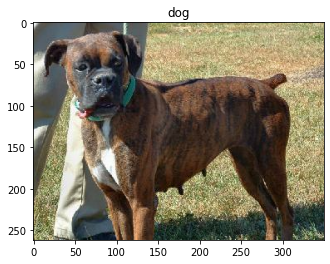

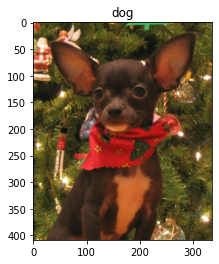

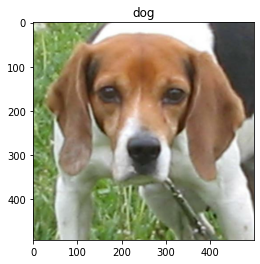

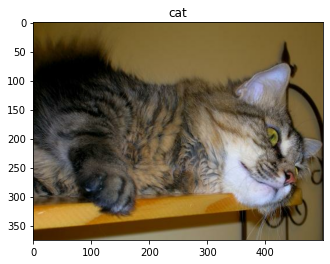

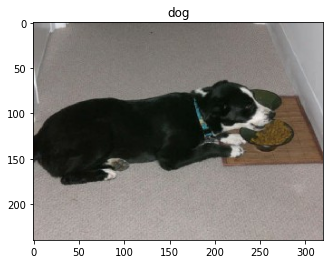

In [6]:
get_label_name = metadata.features['label'].int2str  # creates a function object that we can use to get labels

# display 2 images from the dataset
for image, label in raw_train.take(5):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [7]:
#Resize da imagem

IMG_SIZE = 160 #  160x160

def format_example(image, label):
  """
  returns an image that is reshaped to IMG_SIZE
  """
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

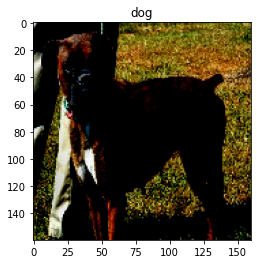

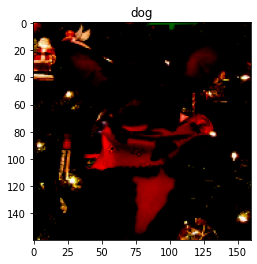

In [9]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

for image, label in train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [10]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

#embaralha as imagens e separa em batchs
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

### Escolhendo um modelo pré-treinado

A `MobileNet V2` desenvolvido no Google e foi treinado com `1,4 milhão de imagens` e possui `1000 classes diferentes` com pesos predeterminados do imagenet (Googles dataset).


In [11]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Cria o base_model referente a MobileNet V2, sem a camada de classificação
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 3s 0us/step


In [12]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [14]:
#Congela a base_model para não atuaizar os pesos quando treinar.

base_model.trainable = False

In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Adicionando um Classificador

In [20]:
#Camada  para gerar um vetor de 1280 elementos 
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# O Classificador para gato cachorro com 1 neuronio 
prediction_layer = keras.layers.Dense(1)

In [22]:
model = tf.keras.Sequential([
  base_model,   #### cnn mobilenet
  global_average_layer, ###flatten
  prediction_layer ### especiallista
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


Pronto! Já criamos a nossa rede para classificação. Agora podemos treinar nossa rede e testar.

### Treinamento do modelo

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
#Avaliação do modelo antes de treiná-lo com novas imagens
initial_epochs = 3
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 8s 385ms/step - loss: 0.6946 - accuracy: 0.5312


In [27]:
# Treinamento da nova CNN
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

acc = history.history['accuracy']
print(acc)

Epoch 1/3
582/582 [==============================] - 280s 472ms/step - loss: 0.2008 - accuracy: 0.9125 - val_loss: 0.0862 - val_accuracy: 0.9695
Epoch 2/3
582/582 [==============================] - 277s 474ms/step - loss: 0.0734 - accuracy: 0.9736 - val_loss: 0.0608 - val_accuracy: 0.9768
Epoch 3/3
582/582 [==============================] - 271s 464ms/step - loss: 0.0583 - accuracy: 0.9792 - val_loss: 0.0530 - val_accuracy: 0.9815
[0.9124664068222046, 0.973616361618042, 0.9792047142982483]


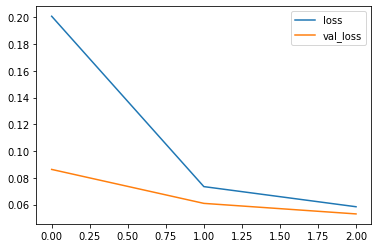

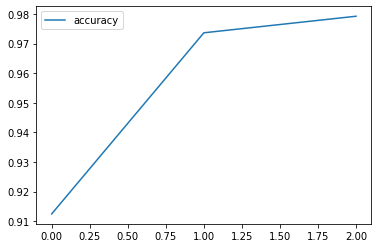

In [44]:
import pandas as pd

metrics_df = pd.DataFrame(history.history)
metrics_df[["loss","val_loss"]].plot();
metrics_df[["accuracy"]].plot();

### Fazendo predições

Predictions:
 [0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0]
Labels:
 [0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0]


<Figure size 720x720 with 0 Axes>

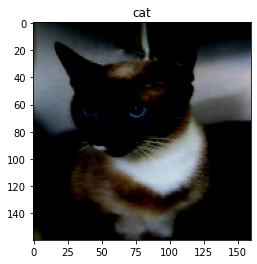

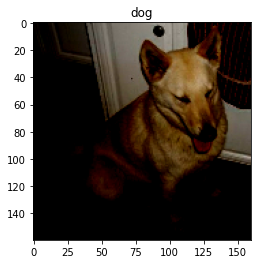

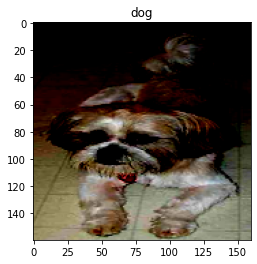

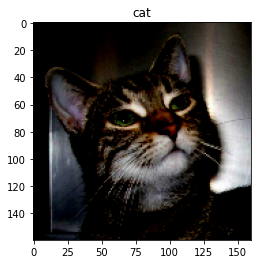

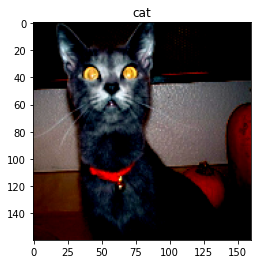

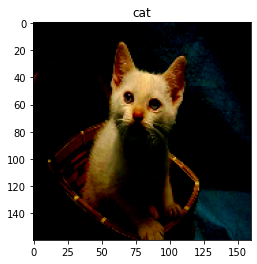

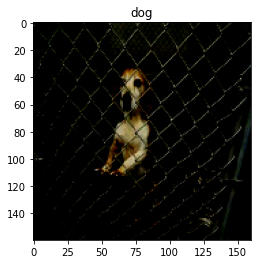

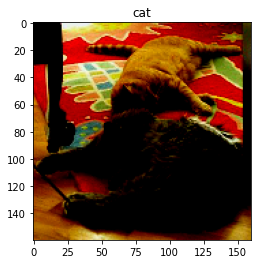

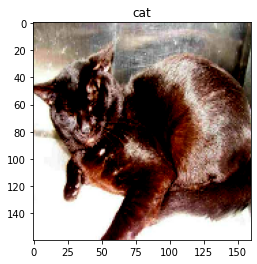

In [39]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_batches.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for image, label in test.take(9):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

### Salvando a rede treinada

In [29]:
# Salvando a rede 
model.save("dogs_vs_cats.h5")

#Carregando uma rede .h5
new_model = tf.keras.models.load_model('dogs_vs_cats.h5')